## Adapting Captain's Code as a Tensor

In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

# Imports 

In [28]:
import numpy as np
import os
import pandas as pd
import sys
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
###  Models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import make_pipeline
### Classes
from src.DataLoader import DataLoader
from src.Tensor import *
### Others imports
from scipy.stats import entropy
from scipy.stats import entropy, kurtosis, skew


# Windows FFT features

## Trian's Code : 

In [ ]:
'''This script defines a function that computes FFT features
(e.g. mean, standard deviation, etc.) from accelerometer data captured by an
Inertial Measurement Unit (IMU). The input is a Pandas DataFrame whose first
three columns represent X, Y, and Z axis accelerations. The function splits the
data into windows and calculates statistical parameters for each one,
consolidating them into a cohesive DataFrame at the end.'''


'''Compute the FFT features of accelerometer data over windows of time
    Args:
        data (pd.DataFrame): Accelerometer data captured by an
            Inertial Measurement Unit (IMU). The first columns of the
            DataFrame should be labelled "X_acceleration", "Y_acceleration",
            respectively "Z_acceleration"
        windows_size (int): The size of the windows into which the input
            DataFrame will be split; measured in seconds
    Returns: pd.DataFrame, pd.DataFrame: Two DataFrames containing the
    computed features:
        - First DataFrame: Contains FFT numerical features (e.g., dominant
        frequencies, entropy, etc.); one value in each cell.
        - Second DataFrame: Contains FFT magnitude spectrograms; a list of
        spectrum magnitudes in each cell.'''

In [19]:
sampling_rate = 32
window_size = 5
window_size *= sampling_rate
len_data = 57600

window_size
num_windows = len_data // window_size
num_windows


360

In [20]:
data = Acc_datas_S1_morning

In [21]:
data

,X_acceleration,Y_acceleration,Z_acceleration,UNIX_time
0,-62.0,18.0,-2.0,1.675144e+09
1,-63.0,18.0,-2.0,1.675144e+09
2,-61.0,15.0,-4.0,1.675144e+09
3,-62.0,15.0,-8.0,1.675144e+09
4,-64.0,14.0,-9.0,1.675144e+09
...,...,...,...,...
57595,-56.0,20.0,29.0,1.675146e+09
57596,-53.0,19.0,30.0,1.675146e+09
57597,-58.0,22.0,33.0,1.675146e+09
57598,-56.0,20.0,31.0,1.675146e+09


In [22]:
for i in range(num_windows):
        # Slice the DataFrame according to the window size
        window_data = data.iloc[i * window_size : (i + 1) * window_size]
        # Transform the DataFrame slice into a Numpy array
        if isinstance(window_data, pd.DataFrame):
            window_data = window_data.to_numpy()

        # Compute the X-axis acceleration FFT over the window interval
        fft_x = np.fft.fft(window_data[:, 0])

In [24]:
fft_x

(160,)

In [4]:

def windows_FFT_features(data, window_size = 5):


    # Declare the input data sampling rate
    sampling_rate = 32 # [Hz]
    # Transform the window size from seconds into number of data entries
    window_size *= sampling_rate
    # Compute the number of windows into which the input data is devided
    num_windows = len(data) // window_size

    # Initialize an empty DataFrame to store computed features
    columns = [
               # X-axis acceleration dominant frequency
               'dominant_freq_x',
               # Y-axis acceleration dominant frequency
               'dominant_freq_y',
               # Z-axis acceleration dominant frequency
               'dominant_freq_z',
               # X-axis acceleration signed entropy
               'entropy_x',
               # Y-axis acceleration signed entropy
               'entropy_y',
               # Z-axis acceleration signed entropy
               'entropy_z',
               # X-axis acceleration low frequency band energy
               'low_freq_band_energy_x',
               # Y-axis acceleration low frequency band energy
               'low_freq_band_energy_y',
               # Z-axis acceleration low frequency band energy
               'low_freq_band_energy_z'
    ]

    # Create an empty Pandas DataFrame to store the features into
    features_df = pd.DataFrame(columns=columns)

    # Create an empty Pandas DataFrame to store the FFT magnitudes into
    magnitudes_df = pd.DataFrame(columns=[
        "FFT_mag_X",
        "FFT_mag_Y",
        "FFT_mag_Z"
        ])

    # Loop over the windows
    for i in range(num_windows):
        # Slice the DataFrame according to the window size
        window_data = data.iloc[i * window_size : (i + 1) * window_size]
        # Transform the DataFrame slice into a Numpy array
        if isinstance(window_data, pd.DataFrame):
            window_data = window_data.to_numpy()

        # Compute the X-axis acceleration FFT over the window interval
        fft_x = np.fft.fft(window_data[:, 0])
        # Compute the Y-axis acceleration FFT over the window interval
        fft_y = np.fft.fft(window_data[:, 1])
        # Compute the Z-axis acceleration FFT over the window interval
        fft_z = np.fft.fft(window_data[:, 2])

        # Compute the FFT frequencies axis
        freq_axis = np.fft.fftfreq(len(window_data), d=1.0 / sampling_rate)

        # Retrieve the positive frequencies of the frequencies axis and exclude
        # the first two bins (the DC component and the first positive
        # frequency), as they do not have much significance (given the way FFT
        # is computed, the maximum amplitude is always achieved for the lowest
        # frequency)

        positive_freq_indices = np.where(freq_axis >= 0)[0][2:]

        # Retrieve the positive frequencies axis

        pos_freq_axis = freq_axis[positive_freq_indices]

        # Compute the X-axis acceleration magnitude spectrum over the window
        # interval
        magnitude_spectrum_x = np.abs(fft_x)
        # Compute the Y-axis acceleration magnitude spectrum over the window
        # interval
        magnitude_spectrum_y = np.abs(fft_y)
        # Compute the Z-axis acceleration magnitude spectrum over the window
        # interval
        magnitude_spectrum_z = np.abs(fft_z)

        # Retrieve magnitudes for positive frequencies within the window
        # interval; the first 2 magnitudes in the spectrum are dropped, as they
        # do not have much significance (given the way FFT is computed, the
        # maximum amplitude is always achieved for the lowest frequency)
        magnitudes = {
            "FFT_mag_X": [magnitude_spectrum_x[positive_freq_indices].tolist()],
            "FFT_mag_Y": [magnitude_spectrum_y[positive_freq_indices].tolist()],
            "FFT_mag_Z": [magnitude_spectrum_z[positive_freq_indices].tolist()]
        }

        # Retrieve the acceleration dominant frequencies for each axis over the
        # window interval from the frequencies axis using the index of the
        # maximum values in the magnitude spectrum after droping the first 2
        # values, as they do not have much significance (given the way FFT is
        # computed, the maximum amplitude is always achieved for the lowest
        # frequency)

        # Retrieve the the X-axis acceleration dominant frequency over the
        # window interval
        dominant_freq_x = pos_freq_axis[np.argmax(magnitude_spectrum_x[
                                        positive_freq_indices].tolist())]
        # Retrieve the the Z-axis acceleration dominant frequency over the
        # window interval
        dominant_freq_y = pos_freq_axis[np.argmax(magnitude_spectrum_y[
                                        positive_freq_indices].tolist())]
        # Retrieve the the Z-axis acceleration dominant frequency over the
        # window interval
        dominant_freq_z = pos_freq_axis[np.argmax(magnitude_spectrum_z[
                                        positive_freq_indices].tolist())]

        # Declare a small constant used to transform null acceleration values
        # into non-null ones so that the logarithm can be computed
        eps = 1e-10

        # Compute the X-axis acceleration signed entropy over the window
        # interval
        entropy_x = np.sum(np.abs(window_data[:, 0]) * np.log(
                                            np.abs(window_data[:, 0] + eps)))
        # Compute the Y-axis acceleration signed entropy over the window
        # interval
        entropy_y = np.sum(np.abs(window_data[:, 1]) * np.log(
                                            np.abs(window_data[:, 1] + eps)))
        # Compute the Z-axis acceleration signed entropy over the window
        # interval
        entropy_z = np.sum(np.abs(window_data[:, 2]) * np.log(
                                            np.abs(window_data[:, 2] + eps)))

        # Compute the X-axis acceleration low-frequency band energy over the
        # window interval
        low_freq_band_energy_x = np.sum(magnitude_spectrum_x[1:10])
        # Compute the Y-axis acceleration low-frequency band energy over the
        # window interval
        low_freq_band_energy_y= np.sum(magnitude_spectrum_y[1:10])
        # Compute the z-axis acceleration low-frequency band energy over the
        # window interval
        low_freq_band_energy_z = np.sum(magnitude_spectrum_z[1:10])


        # Retrieve features within the window interval
        features = {
            # Retrieve the X-axis acceleration dominant frequnecy over the
            # window interval
            'dominant_freq_x': dominant_freq_x,
            # Retrieve the Y-axis acceleration dominant frequnecy over the
            # window interval
            'dominant_freq_y': dominant_freq_y,
            # Retrieve the Z-axis acceleration dominant frequnecy over the
            # window interval
            'dominant_freq_z': dominant_freq_z,
            # Retrieve X-axis acceleration entropy over the window interval
            'entropy_x': entropy_x,
            # Retrieve Y-axis acceleration entropy over the window interval
            'entropy_y': entropy_y,
            # Retrieve Z-axis acceleration entropy over the window interval
            'entropy_z': entropy_z,
            # Retrieve X-axis acceleration low frequency band energy over the
            # window interval
            'low_freq_band_energy_x': low_freq_band_energy_x,
            # Retrieve Y-axis acceleration low frequency band energy over the
            # window interval
            'low_freq_band_energy_y': low_freq_band_energy_y,
            # Retrieve Z-axis acceleration low frequency band energy over the
            # window interval
            'low_freq_band_energy_z': low_freq_band_energy_z
        }

        # Make a Pandas DataFrame from the features computed for each window
        features = pd.DataFrame(features, index = [0])

        # Make a Pandas DataFrame from the magnitudes computed for each window
        magnitudes = pd.DataFrame(magnitudes)

        # Append features to the DataFrame
        features_df = pd.concat([features_df, features], ignore_index=True)

        # Append magnitudes to the DataFrame
        magnitudes_df = pd.concat([magnitudes_df, magnitudes], ignore_index=True)

    return features_df, magnitudes_df


## Testing the code 

In [7]:
Acc_datas_S1_morning = DataLoader().load_ACC_data(subject = "S1", event = "morning")

In [8]:
Acc_datas_S1_morning

,X_acceleration,Y_acceleration,Z_acceleration,UNIX_time
0,-62.0,18.0,-2.0,1.675144e+09
1,-63.0,18.0,-2.0,1.675144e+09
2,-61.0,15.0,-4.0,1.675144e+09
3,-62.0,15.0,-8.0,1.675144e+09
4,-64.0,14.0,-9.0,1.675144e+09
...,...,...,...,...
57595,-56.0,20.0,29.0,1.675146e+09
57596,-53.0,19.0,30.0,1.675146e+09
57597,-58.0,22.0,33.0,1.675146e+09
57598,-56.0,20.0,31.0,1.675146e+09


In [9]:
Acc_datas_S1_morning.shape

(57600, 4)

In [10]:
FFT_Features_S1_morning = windows_FFT_features(Acc_datas_S1_morning, window_size = 5)

/tmp/ipykernel_7640/1790693257.py:200: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  features_df = pd.concat([features_df, features], ignore_index=True)


In [15]:
type(FFT_Features_S1_morning)
FFT_Features_S1_morning
len(FFT_Features_S1_morning)
FFT_Features_S1_morning[0]

,dominant_freq_x,dominant_freq_y,dominant_freq_z,entropy_x,entropy_y,entropy_z,low_freq_band_energy_x,low_freq_band_energy_y,low_freq_band_energy_z
0,2.0,0.6,1.2,41470.273481,6410.659041,5498.902245,1326.019805,544.565497,3625.488224
1,1.8,1.0,0.6,38997.696583,12104.053750,4518.891631,1342.257676,1253.953604,2254.737613
2,2.4,1.4,1.4,37437.447430,10191.598836,9358.332022,1875.191050,1796.341257,6223.800386
3,1.8,0.4,1.8,40722.703141,9718.806786,3165.616603,981.835117,1633.777014,2559.291145
4,1.2,0.4,1.2,39044.757902,9409.797235,7048.798470,1984.960675,1303.935939,5055.981190
...,...,...,...,...,...,...,...,...,...
355,1.6,0.4,0.6,43172.924423,1949.650463,4557.604438,625.415016,1896.462693,2952.160567
356,4.8,0.6,0.6,44008.333256,368.728061,2636.820992,289.877071,584.802336,1829.779370
357,0.4,0.4,0.4,39217.294614,4909.260106,11741.483604,1055.466678,1303.196277,3096.228314
358,0.6,1.2,0.8,35269.997748,16934.080784,8835.407735,1710.411005,2932.196883,4726.352759


In [16]:
FFT_Features_S1_morning[1]

,FFT_mag_X,FFT_mag_Y,FFT_mag_Z
0,"[120.01242231458863, 75.93079572331348, 98.777...","[52.12114928102213, 137.6496284530983, 52.2906...","[89.17506016746776, 277.50728684525546, 479.60..."
1,"[70.03263908665892, 173.99530553617294, 98.224...","[97.07843988754874, 97.47421296380564, 54.4171...","[213.00760397347918, 251.7883963147413, 181.15..."
2,"[108.8458415028501, 153.32830722264472, 71.597...","[134.42540170969158, 95.1132425938849, 125.523...","[663.8065627289242, 604.7822129724564, 395.519..."
3,"[160.25131738967, 47.327703520683535, 79.22622...","[289.3372885693261, 83.00267605315415, 120.087...","[346.31047090056325, 170.12012292618206, 354.3..."
4,"[227.6685856583476, 144.8171788298696, 118.733...","[282.54227192448946, 60.74570716215766, 54.395...","[266.7527521882455, 580.5123380631824, 480.147..."
...,...,...,...
355,"[6.65473433907045, 80.82305542006316, 109.9581...","[380.40650615920913, 159.442606987097, 308.478...","[153.27686736987414, 526.74807235358, 362.2689..."
356,"[47.892833961720235, 6.718697795886567, 28.362...","[74.10538408881003, 164.67287436314047, 3.7500...","[117.83769305458847, 303.71884581516707, 227.5..."
357,"[395.3046945731889, 95.64360047029855, 50.6878...","[383.26684543428155, 179.58866552024492, 269.3...","[994.3672411139885, 325.93690927521135, 244.88..."
358,"[185.5438477363008, 418.9489219025356, 127.251...","[199.58534427114137, 291.07659608128955, 75.21...","[705.6412504352259, 789.1811557528436, 857.284..."


## Create a Tensor based on that :
> a list : each element is a subject (morning or evening) <b>
>> each element contains these two Dataframes </b>

# Window statistical features 

In [25]:
def windows_statistical_features(data, window_size = 5):
    '''Compute the essential statistical features of accelerometer data over
    windows of time
        Args:
            data (pd.DataFrame): Accelerometer data captured by an
                Inertial Measurement Unit (IMU). The first columns of the
                DataFrame should be labelled "X_acceleration", "Y_acceleration",
                respectively "Z_acceleration"
            windows_size (int): The size of the windows into which the input
                DataFrame will be split; measured in seconds
        Returns:
            pd.DataFrame: DataFrame containing the statistical features.'''

    # Declare the input data sampling rate
    sampling_rate = 32 # [Hz]
    # Transform the window size from seconds into number of data entries
    window_size *= sampling_rate
    # Compute the number of windows into which the input data is devided
    num_windows = len(data) // window_size

    # Initialize an empty DataFrame to store computed features
    columns = [
                # X-axis acceleration mean over the window interval
               'mean_x',
               # Y-axis acceleration mean over the window interval
               'mean_y',
               # Z-axis acceleration mean over the window interval
               'mean_z',
               # X-axis acceleration standard deviation over the window interval
               'std_x',
               # Y-axis acceleration standard deviation over the window interval
               'std_y',
               # Z-axis acceleration standard deviation over the window interval
               'std_z',
               # X-axis acceleration variation over the window interval
                'var_x',
               # Y-axis acceleration variation over the window interval
                'var_y',
               # Z-axis acceleration variation over the window interval
                'var_z',
               # Energy (Euclidean norm) over the window interval
                'energy',
               # Entropy over the window interval
            #    'entropy',
               # X-axis acceleration skew over the window interval
                'skew_x',
               # Y-axis acceleration skew over the window interval
                'skew_y',
               # Z-axis acceleration skew over the window interval
                'skew_z',
               # X-axis acceleration kurtosis over the window interval
                'kurt_x',
               # Y-axis acceleration kurtosis over the window interval
                'kurt_y',
               # Z-axis acceleration kurtosis over the window interval
                'kurt_z',
               # X-axis acceleration range over the window interval
                'range_x',
               # Y-axis acceleration range over the window interval
                'range_y',
               # Z-axis acceleration range over the window interval
                'range_z',
               # X-axis acceleration bottom quarter percentile over the window
               # interval
                'p25_x',
               # X-axis acceleration half percentile over the window interval
                'p50_x',
               # X-axis acceleration top quarter percentile over the window
               # interval
                'p75_x',
               # Y-axis acceleration bottom quarter percentile over the window
               # interval
                'p25_y',
               # Y-axis acceleration half percentile over the window interval
                'p50_y',
               # Y-axis acceleration top quarter percentile over the window
               # interval
                'p75_y',
               # Z-axis acceleration bottom quarter percentile over the window
               # interval
                'p25_z',
               # Z-axis acceleration half percentile over the window interval
                'p50_z',
               # Z-axis acceleration top quarter percentile over the window
               # interval
                'p75_z',
            #    'approx_entropy',
            #    'sample_entropy',
            #    'perm_entropy'
               ]

    # Aceleration axes labels
    axis_labels = ["X", "Y", "Z"]

    # Add cross-correlation columns
    for i in range(len(axis_labels)):
        for j in range(i + 1, len(axis_labels)):
            columns.append(f"cross_corr_{axis_labels[i]}_{axis_labels[j]}")

    # Create an empty Pandas DataFrame to store the features into
    features_df = pd.DataFrame(columns=columns)

    # Loop over the windows
    for i in range(num_windows):
        # Slice the DataFrame according to the window size
        window_data = data.iloc[i * window_size : (i + 1) * window_size]
        # Transform the DataFrame slice into a Numpy array
        if isinstance(window_data, pd.DataFrame):
            window_data = window_data.to_numpy()

        # Compute features within the window
        features = {
            # Compute the X-axis acceleration mean over the window interval
            'mean_x': np.mean(window_data[:, 0]),
            # Compute the Y-axis acceleration mean over the window interval
            'mean_y': np.mean(window_data[:, 1]),
            # Compute the Z-axis acceleration mean over the window interval
            'mean_z': np.mean(window_data[:, 2]),
            # Compute the X-axis acceleration standard deviation over the window
            # interval
            'std_x': np.std(window_data[:, 0]),
            # Compute the Y-axis acceleration standard deviation over the window
            # interval
            'std_y': np.std(window_data[:, 1]),
            # Compute the Z-axis acceleration standard deviation over the window
            # interval
            'std_z': np.std(window_data[:, 2]),
            # Compute the X-axis acceleration variance over the window interval
             'var_x': np.var(window_data[:, 0]),
            # Compute the Y-axis acceleration variance over the window interval
             'var_y': np.var(window_data[:, 1]),
            # Compute the Z-axis acceleration variance over the window interval
             'var_z': np.var(window_data[:, 2]),
            # Compute the energy (euclidean norm) along over the window interval
             'energy': np.linalg.norm(window_data[:, :3], axis = None),
            # Compute entropy over the window interval
            # 'entropy': -np.sum(np.abs(window_data) *
            #                    np.log2(np.abs(window_data))),
            # Compute the X-axis acceleration skew over the window interval
             'skew_x': skew(window_data[:, 0]),
            # Compute the Y-axis acceleration skew over the window interval
             'skew_y': skew(window_data[:, 1]),
            # Compute the Z-axis acceleration skew over the window interval
             'skew_z': skew(window_data[:, 2]),
            # Compute the X-axis acceleration kurtosis over the window interval
             'kurt_x': kurtosis(window_data[:, 0]),
            # Compute the Y-axis acceleration kurtosis over the window interval
             'kurt_y': kurtosis(window_data[:, 1]),
            # Compute the Z-axis acceleration kurtosis over the window interval
             'kurt_z': kurtosis(window_data[:, 2]),
            # Compute the X-axis acceleration range over the window interval
             'range_x': np.max(window_data[:, 0]) - np.min(window_data[:, 0]),
            # Compute the Y-axis acceleration range over the window interval
             'range_y': np.max(window_data[:, 1]) - np.min(window_data[:, 1]),
            # Compute the Z-axis acceleration range over the window interval
             'range_z': np.max(window_data[:, 2]) - np.min(window_data[:, 2]),
            # Compute the X-axis acceleration bottom quarter percentile over the
            # window interval
             'p25_x': np.percentile(window_data[:, 0], 25),
            # Compute the X-axis acceleration half percentile over the window
            # interval
             'p50_x': np.percentile(window_data[:, 0], 50),
            # Compute the  X-axis acceleration top quarter percentile over the
            # window interval
             'p75_x': np.percentile(window_data[:, 0], 75),
            # Compute the Y-axis acceleration bottom quarter percentile over the
            # window interval
             'p25_y': np.percentile(window_data[:, 1], 25),
            # Compute the Y-axis acceleration half percentile over the window
            # interval
             'p50_y': np.percentile(window_data[:, 1], 50),
            # Compute the  Y-axis acceleration top quarter percentile over the
            # window interval
             'p75_y': np.percentile(window_data[:, 1], 75),
            # Compute the Z-axis acceleration bottom quarter percentile over the
            # window interval
             'p25_z': np.percentile(window_data[:, 2], 25),
            # Compute the Z-axis acceleration half percentile over the window
            # interval
             'p50_z': np.percentile(window_data[:, 2], 50),
            # Compute the  Z-axis acceleration top quarter percentile over the
            # window interval
             'p75_z': np.percentile(window_data[:, 2], 75),
            # 'approx_entropy': app_entropy(window_data.flatten()),
            # 'sample_entropy': sample_entropy(window_data.flatten()),
            # 'perm_entropy': perm_entropy(window_data.flatten())
        }

        # Compute cross-correlation
        for i in range(3):
            for j in range(i + 1, 3):
                features[f"cross_corr_{axis_labels[i]}_{axis_labels[j]}"] = np.corrcoef(
                    window_data[:, i],
                    window_data[:, j]
                    )[0, 1]

        # Make a Pandas DataFrame from the features computed for each window
        features = pd.DataFrame(features, index = [0])

        # Append features to the DataFrame
        features_df = pd.concat([features_df, features], ignore_index=True)

    return features_df


In [29]:
dataS = Acc_datas_S1_morning

In [30]:
data_stats = windows_statistical_features(dataS, window_size = 5)

/tmp/ipykernel_7640/2279255394.py:201: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  features_df = pd.concat([features_df, features], ignore_index=True)
/tmp/ipykernel_7640/2279255394.py:140: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skew_x': skew(window_data[:, 0]),
/tmp/ipykernel_7640/2279255394.py:146: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurt_x': kurtosis(window_data[:, 0]),
/home/marie/.pyenv/versions/3.10.6/envs/walkies/lib/python3.10/site-packages/numpy/lib/function_bas

In [31]:
data_stats

,mean_x,mean_y,mean_z,std_x,std_y,std_z,var_x,var_y,var_z,energy,skew_x,skew_y,skew_z,kurt_x,kurt_y,kurt_z,range_x,range_y,range_z,p25_x,p50_x,p75_x,p25_y,p50_y,p75_y,p25_z,p50_z,p75_z,cross_corr_X_Y,cross_corr_X_Z,cross_corr_Y_Z
0,-62.51875,14.71250,-5.43750,8.873396,3.821628,15.280988,78.737148,14.604844,233.508594,846.779192,0.188582,0.234401,0.213838,1.353332,0.760091,1.467021,58.0,23.0,89.0,-68.00,-63.0,-58.00,12.00,14.0,17.00,-12.00,-6.0,1.00,0.134016,0.615978,0.191131
1,-59.56250,23.71250,9.82500,5.929468,5.103170,9.501677,35.158594,26.042344,90.281875,835.031736,0.495190,-0.345675,0.743217,0.974332,-0.259824,0.419082,35.0,24.0,50.0,-63.00,-60.0,-57.00,20.00,25.0,27.25,3.75,7.0,19.00,0.413125,0.709228,0.487092
2,-57.27500,20.48750,-2.47500,13.216443,8.116332,23.258587,174.674375,65.874844,540.961875,847.377130,0.783537,0.299474,-0.416730,4.757889,0.228802,0.053384,119.0,51.0,117.0,-66.00,-58.0,-51.00,14.75,19.0,27.00,-17.00,0.0,13.25,0.348274,0.266942,0.396242
3,-61.65000,19.88125,3.76875,6.960783,7.153995,9.932410,48.452500,51.179648,98.652773,839.854749,1.609167,0.478106,0.690797,6.591321,0.124045,0.756032,49.0,45.0,62.0,-65.00,-62.0,-59.00,14.00,19.0,26.25,-3.00,1.0,12.00,0.411373,0.568610,0.123283
4,-59.53125,19.51875,2.69375,9.201849,5.550869,18.853381,84.674023,30.812148,355.449961,839.346770,0.694042,0.154883,0.097754,2.022536,-0.299349,0.553231,63.0,29.0,112.0,-65.00,-60.0,-54.75,15.00,19.0,23.00,-10.00,2.0,13.00,0.377251,0.739648,0.483290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,-64.68750,-2.21875,-5.40625,3.799979,6.755250,11.855008,14.439844,45.633398,140.541211,840.879302,-0.017411,0.607882,-0.204715,1.353342,-0.563136,-1.398665,24.0,27.0,44.0,-67.00,-65.0,-63.00,-8.00,-3.0,1.00,-18.00,-4.5,6.00,0.125132,-0.189612,-0.505115
356,-65.70625,-0.06875,-3.45625,2.767212,2.702133,8.494003,7.657461,7.301523,72.148086,840.606329,0.409171,-0.063989,-0.143937,1.021955,0.002162,-0.331153,16.0,14.0,42.0,-67.25,-66.0,-64.75,-1.25,0.0,2.00,-8.00,-3.0,3.00,-0.122677,-0.113423,-0.103755
357,-59.78125,11.65000,-21.23125,8.165225,6.752037,14.948337,66.670898,45.590000,223.452773,848.150930,-0.371994,0.751806,-0.008218,5.501894,1.158949,-0.291026,73.0,36.0,73.0,-64.00,-59.0,-56.00,7.00,11.0,15.00,-31.00,-22.5,-11.75,0.392043,-0.271539,-0.299395
358,-54.74375,29.21250,8.77500,11.493611,17.657289,20.190019,132.103086,311.779844,407.636875,874.415805,0.468725,0.832888,-0.151984,1.199662,9.653840,-0.059812,77.0,190.0,107.0,-63.00,-55.0,-47.75,21.00,26.0,35.00,-3.00,8.5,23.00,0.207823,0.267667,0.382409


# Models

## PCA model

In [237]:
datas_subjects_list = Tensor_data()
datas_subjects_list

[       X_acceleration  Y_acceleration  Z_acceleration
 0               -62.0            18.0            -2.0
 1               -63.0            18.0            -2.0
 2               -61.0            15.0            -4.0
 3               -62.0            15.0            -8.0
 4               -64.0            14.0            -9.0
 ...               ...             ...             ...
 57595           -56.0            20.0            29.0
 57596           -53.0            19.0            30.0
 57597           -58.0            22.0            33.0
 57598           -56.0            20.0            31.0
 57599           -58.0            19.0            33.0
 
 [57600 rows x 3 columns],
        X_acceleration  Y_acceleration  Z_acceleration
 0               -63.0           -15.0            25.0
 1               -65.0           -12.0            21.0
 2               -65.0           -10.0            19.0
 3               -65.0            -8.0            18.0
 4               -64.0            -8

In [35]:
Xlist_normalized = normalize_list_data(datas_subjects_list)
Xlist_normalized

[       X_acceleration  Y_acceleration  Z_acceleration
 0           -0.589457       -0.114222       -0.212423
 1           -0.671152       -0.114222       -0.212423
 2           -0.507761       -0.269832       -0.308387
 3           -0.589457       -0.269832       -0.500315
 4           -0.752848       -0.321702       -0.548297
 ...               ...             ...             ...
 57595       -0.099284       -0.010482        1.275020
 57596        0.145802       -0.062352        1.323002
 57597       -0.262675        0.093258        1.466948
 57598       -0.099284       -0.010482        1.370984
 57599       -0.262675       -0.062352        1.466948
 
 [57600 rows x 3 columns],
        X_acceleration  Y_acceleration  Z_acceleration
 0           -0.743233       -0.771796        0.160711
 1           -0.874754       -0.629046        0.004586
 2           -0.874754       -0.533879       -0.073476
 3           -0.874754       -0.438712       -0.112508
 4           -0.808993       -0.4387

In [40]:
X_tensor_normalized = np.array([df[['X_acceleration', 'Y_acceleration', 'Z_acceleration']].values for df in Xlist_normalized])
X_tensor_normalized.shape

(46, 57600, 3)

In [41]:
Y_label = label_creator()
Y_label

,fatigue,is_tired
0,11,0
1,18,1
2,0,0
3,12,1
4,10,0
5,11,0
6,5,0
7,11,0
8,2,0
9,5,0


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X_tensor_normalized, Y_label["is_tired"], test_size=0.3)

In [43]:
X_train[:,:,0].shape

(32, 57600)

In [46]:
X_train.shape

(32, 57600, 3)

In [ ]:
# rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)

# rnd_clf.fit(X_train[:,:,2], y_train)

In [231]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(X_train)

PCA()

# Polynomial Features

In [50]:
def magnitude_acceleration(d):
    return np.sqrt(d[0]**2+d[1]**2+d[2]**2)

In [52]:
Acc_datas_S1_morning_2 = DataLoader().load_ACC_data(subject = "S1", event = "morning")
Acc_datas_S1_morning_2

,X_acceleration,Y_acceleration,Z_acceleration,UNIX_time
0,-62.0,18.0,-2.0,1.675144e+09
1,-63.0,18.0,-2.0,1.675144e+09
2,-61.0,15.0,-4.0,1.675144e+09
3,-62.0,15.0,-8.0,1.675144e+09
4,-64.0,14.0,-9.0,1.675144e+09
...,...,...,...,...
57595,-56.0,20.0,29.0,1.675146e+09
57596,-53.0,19.0,30.0,1.675146e+09
57597,-58.0,22.0,33.0,1.675146e+09
57598,-56.0,20.0,31.0,1.675146e+09


In [53]:
Acc_datas_S1_morning_2['mag_acc'] = Acc_datas_S1_morning_2.apply(magnitude_acceleration, axis = 1)

/tmp/ipykernel_7640/2729946542.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.sqrt(d[0]**2+d[1]**2+d[2]**2)


In [114]:
Acc_datas_S1_morning_2

,X_acceleration,Y_acceleration,Z_acceleration,UNIX_time,mag_acc
0,-62.0,18.0,-2.0,1.675144e+09,64.591021
1,-63.0,18.0,-2.0,1.675144e+09,65.551506
2,-61.0,15.0,-4.0,1.675144e+09,62.944420
3,-62.0,15.0,-8.0,1.675144e+09,64.288413
4,-64.0,14.0,-9.0,1.675144e+09,66.128662
...,...,...,...,...,...
57595,-56.0,20.0,29.0,1.675146e+09,66.158900
57596,-53.0,19.0,30.0,1.675146e+09,63.796552
57597,-58.0,22.0,33.0,1.675146e+09,70.263789
57598,-56.0,20.0,31.0,1.675146e+09,67.059675


In [77]:
display(Xlist_normalized)
display(len(Xlist_normalized))
display(Xlist_normalized[0].shape)

[       X_acceleration  Y_acceleration  Z_acceleration
 0           -0.589457       -0.114222       -0.212423
 1           -0.671152       -0.114222       -0.212423
 2           -0.507761       -0.269832       -0.308387
 3           -0.589457       -0.269832       -0.500315
 4           -0.752848       -0.321702       -0.548297
 ...               ...             ...             ...
 57595       -0.099284       -0.010482        1.275020
 57596        0.145802       -0.062352        1.323002
 57597       -0.262675        0.093258        1.466948
 57598       -0.099284       -0.010482        1.370984
 57599       -0.262675       -0.062352        1.466948
 
 [57600 rows x 3 columns],
        X_acceleration  Y_acceleration  Z_acceleration
 0           -0.743233       -0.771796        0.160711
 1           -0.874754       -0.629046        0.004586
 2           -0.874754       -0.533879       -0.073476
 3           -0.874754       -0.438712       -0.112508
 4           -0.808993       -0.4387

46

(57600, 3)

In [78]:
for elm in Xlist_normalized:
    elm['mag_acc'] = elm.apply(magnitude_acceleration, axis = 1)

/tmp/ipykernel_7640/2729946542.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.sqrt(d[0]**2+d[1]**2+d[2]**2)
/tmp/ipykernel_7640/2729946542.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.sqrt(d[0]**2+d[1]**2+d[2]**2)
/tmp/ipykernel_7640/2729946542.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  return np.sqrt(d[0]**2+d[1]**2+d[2]**2)
/tmp/ipykernel_7640/2729946542.py:2: FutureWarning: Series.__getite

In [124]:
Xlist_normalized[0][['mag_acc']].iloc[9600:]

,mag_acc
9600,1.365529
9601,1.416695
9602,1.416695
9603,1.469478
9604,1.534901
...,...
57595,1.278923
57596,1.332472
57597,1.493195
57598,1.374614


In [83]:
display(Xlist_normalized)
display(len(Xlist_normalized))
display(Xlist_normalized[0].shape)

[       X_acceleration  Y_acceleration  Z_acceleration   mag_acc
 0           -0.589457       -0.114222       -0.212423  0.636891
 1           -0.671152       -0.114222       -0.212423  0.713173
 2           -0.507761       -0.269832       -0.308387  0.652483
 3           -0.589457       -0.269832       -0.500315  0.818892
 4           -0.752848       -0.321702       -0.548297  0.985344
 ...               ...             ...             ...       ...
 57595       -0.099284       -0.010482        1.275020  1.278923
 57596        0.145802       -0.062352        1.323002  1.332472
 57597       -0.262675        0.093258        1.466948  1.493195
 57598       -0.099284       -0.010482        1.370984  1.374614
 57599       -0.262675       -0.062352        1.466948  1.491584
 
 [57600 rows x 4 columns],
        X_acceleration  Y_acceleration  Z_acceleration   mag_acc
 0           -0.743233       -0.771796        0.160711  1.083463
 1           -0.874754       -0.629046        0.004586  1.077

46

(57600, 4)

In [ ]:
#### From Xlist_normalized, create a shape where columns = [5lastminwalks]
# metrics = precision
# raws = subjects
#phyphox : name of the app

In [161]:
acc_magn_list = []
for elements in Xlist_normalized:
    acc_magn_list.append(elements[['mag_acc']].iloc[9600:])
acc_magn_list

[        mag_acc
 9600   1.365529
 9601   1.416695
 9602   1.416695
 9603   1.469478
 9604   1.534901
 ...         ...
 57595  1.278923
 57596  1.332472
 57597  1.493195
 57598  1.374614
 57599  1.491584
 
 [48000 rows x 1 columns],
         mag_acc
 9600   0.921411
 9601   0.919641
 9602   0.911038
 9603   0.909247
 9604   0.921411
 ...         ...
 57595  1.294507
 57596  1.294507
 57597  1.320585
 57598  1.347289
 57599  1.347289
 
 [48000 rows x 1 columns],
         mag_acc
 9600   1.712382
 9601   1.956468
 9602   1.563243
 9603   1.096594
 9604   2.134599
 ...         ...
 57595  2.508832
 57596  2.431972
 57597  2.334966
 57598  2.161201
 57599  2.077737
 
 [48000 rows x 1 columns],
         mag_acc
 9600   1.035972
 9601   1.116814
 9602   0.971113
 9603   0.631542
 9604   1.240044
 ...         ...
 57595  1.490152
 57596  1.434914
 57597  1.303662
 57598  1.479825
 57599  1.114110
 
 [48000 rows x 1 columns],
         mag_acc
 9600   1.387358
 9601   1.347593
 9602   1.392604


In [203]:
acc_magn_list

len(acc_magn_list)
table_X = acc_magn_list[0].T
for i in range(1,46):
    table_X = pd.concat([table_X,acc_magn_list[i].T], axis = 0)

In [212]:
table_X.index = [f'S_{i}' for i in range(1,47)]
table_X

,9600,9601,9602,9603,9604,9605,9606,9607,9608,9609,9610,9611,9612,9613,9614,9615,9616,9617,9618,9619,9620,9621,9622,9623,9624,9625,9626,9627,9628,9629,9630,9631,9632,9633,9634,9635,9636,9637,9638,9639,...,57560,57561,57562,57563,57564,57565,57566,57567,57568,57569,57570,57571,57572,57573,57574,57575,57576,57577,57578,57579,57580,57581,57582,57583,57584,57585,57586,57587,57588,57589,57590,57591,57592,57593,57594,57595,57596,57597,57598,57599
S_1,1.365529,1.416695,1.416695,1.469478,1.534901,1.475558,1.467779,1.520303,1.520303,1.724010,1.621686,1.465820,1.573699,1.509329,1.844950,1.896323,1.757634,1.846513,1.750360,2.074862,1.958533,1.884631,1.897101,2.307340,1.936756,1.793585,2.280393,2.117113,1.877180,1.956520,1.496353,1.861272,1.572642,1.634419,1.647516,1.780075,1.362583,1.669208,1.951186,1.695227,...,0.683666,0.620923,0.847514,0.843122,0.678158,0.776878,0.707498,0.867930,0.826128,0.996287,0.843717,0.513487,0.717839,0.616311,0.714801,0.828155,1.099348,1.005516,0.969717,0.951596,0.956482,1.067673,1.085038,1.085776,1.182383,1.247993,1.274489,1.161222,1.278152,1.229408,1.196505,1.444397,1.039913,1.276674,1.301839,1.278923,1.332472,1.493195,1.374614,1.491584
S_2,0.921411,0.919641,0.911038,0.909247,0.921411,0.911038,0.881377,0.883225,0.909247,0.921411,0.911038,0.911038,0.921411,0.921411,0.921411,0.909247,0.911038,0.919641,0.919641,0.881377,0.909247,0.911038,0.911038,0.921411,0.921411,0.911038,0.909247,0.909247,0.909247,0.909247,0.909247,0.919641,0.919641,0.919641,0.911038,0.911038,0.911038,0.921411,0.870527,0.864556,...,1.330356,1.368198,1.368198,1.442179,1.377631,1.320585,1.352653,1.377631,1.377631,1.330356,1.279258,1.328353,1.328353,1.220426,1.146323,1.146323,1.170498,1.220426,1.271794,1.356130,1.304768,1.294804,1.220426,1.197259,1.324436,1.208028,1.197259,1.197259,1.220426,1.096966,1.170498,1.230992,1.304768,1.318567,1.328353,1.294507,1.294507,1.320585,1.347289,1.347289
S_3,1.712382,1.956468,1.563243,1.096594,2.134599,2.337121,0.518026,1.030608,0.709471,1.180761,1.002294,0.786800,0.660726,0.865923,1.110174,1.492310,0.570977,1.087173,1.531100,2.332631,2.343888,2.117991,2.095971,2.096167,2.049440,1.899168,1.488074,1.744136,2.162780,1.796289,1.752391,0.894491,0.640394,0.595852,0.874963,0.838021,0.843665,0.749063,1.395289,1.466159,...,2.942213,2.962468,3.000485,2.950543,3.000485,2.992883,2.955756,3.003067,3.074588,3.119538,3.056696,3.101781,3.203846,3.119511,2.751313,2.462040,2.340806,2.065340,1.832363,1.473524,1.795366,1.961924,1.897458,1.840882,2.137930,2.344916,2.568884,2.400857,2.340072,2.511893,2.546858,3.810395,2.661874,2.243056,2.401625,2.508832,2.431972,2.334966,2.161201,2.077737
S_4,1.035972,1.116814,0.971113,0.631542,1.240044,1.156776,0.945021,0.955622,1.006670,1.171823,1.159338,1.215483,1.123568,0.912266,0.846788,0.887475,0.634606,0.833929,0.816362,0.646379,0.713271,0.853049,1.042248,1.169533,1.201125,1.196253,1.437080,1.542444,1.355337,1.140177,1.310141,1.109802,1.491495,1.234130,1.447600,1.768315,1.683131,2.514086,2.390050,2.850026,...,0.881804,0.807359,0.734735,0.809994,0.791363,0.834859,0.948039,0.943239,0.960791,0.991808,0.994453,1.059241,1.243323,1.407054,1.499367,1.170586,1.192644,1.418791,1.480604,1.480604,1.579898,1.656170,1.613067,1.709576,1.799243,1.553427,1.508234,1.522613,1.504594,1.353950,1.193225,1.099654,0.897522,0.982312,1.180565,1.490152,1.434914,1.303662,1.479825,1.114110
S_5,1.387358,1.347593,1.392604,1.352993,1.347593,1.347593,1.383379,1.352993,1.352993,1.359151,1.359151,1.359151,1.359183,1.316642,1.323771,1.321139,1.328243,1.291983,1.328243,1.291983,1.274789,1.412604,1.336104,1.170209,1.347593,1.406019,1.442510,1.231501,1.239012,1.222655,1.079530,1.153851,1.068038,0.898922,1.007267,1.002853,1.411340,1.133215,1.091887,1.107280,...,1.002294,0.925491,0.889061,0.856027,0.949055,0.864627,0.920123,0.971942,0.950449,0.902756,1.051891,0.903897,0.856027,1.017684,0.906628,0.930363,1.065693,0.859398,1.025551,0.728792,1.182641,0.856565,0.906335,1.057593,0.997836,0.979874,1.065693,1.040871,1.040871,1.005977,0.974

In [214]:
X_table_5min = table_X
X_table_5min.index = [f'S_{i}' for i in range(1,47)]
X_table_5min

,9600,9601,9602,9603,9604,9605,9606,9607,9608,9609,9610,9611,9612,9613,9614,9615,9616,9617,9618,9619,9620,9621,9622,9623,9624,9625,9626,9627,9628,9629,9630,9631,9632,9633,9634,9635,9636,9637,9638,9639,...,57560,57561,57562,57563,57564,57565,57566,57567,57568,57569,57570,57571,57572,57573,57574,57575,57576,57577,57578,57579,57580,57581,57582,57583,57584,57585,57586,57587,57588,57589,57590,57591,57592,57593,57594,57595,57596,57597,57598,57599
S_1,1.365529,1.416695,1.416695,1.469478,1.534901,1.475558,1.467779,1.520303,1.520303,1.724010,1.621686,1.465820,1.573699,1.509329,1.844950,1.896323,1.757634,1.846513,1.750360,2.074862,1.958533,1.884631,1.897101,2.307340,1.936756,1.793585,2.280393,2.117113,1.877180,1.956520,1.496353,1.861272,1.572642,1.634419,1.647516,1.780075,1.362583,1.669208,1.951186,1.695227,...,0.683666,0.620923,0.847514,0.843122,0.678158,0.776878,0.707498,0.867930,0.826128,0.996287,0.843717,0.513487,0.717839,0.616311,0.714801,0.828155,1.099348,1.005516,0.969717,0.951596,0.956482,1.067673,1.085038,1.085776,1.182383,1.247993,1.274489,1.161222,1.278152,1.229408,1.196505,1.444397,1.039913,1.276674,1.301839,1.278923,1.332472,1.493195,1.374614,1.491584
S_2,0.921411,0.919641,0.911038,0.909247,0.921411,0.911038,0.881377,0.883225,0.909247,0.921411,0.911038,0.911038,0.921411,0.921411,0.921411,0.909247,0.911038,0.919641,0.919641,0.881377,0.909247,0.911038,0.911038,0.921411,0.921411,0.911038,0.909247,0.909247,0.909247,0.909247,0.909247,0.919641,0.919641,0.919641,0.911038,0.911038,0.911038,0.921411,0.870527,0.864556,...,1.330356,1.368198,1.368198,1.442179,1.377631,1.320585,1.352653,1.377631,1.377631,1.330356,1.279258,1.328353,1.328353,1.220426,1.146323,1.146323,1.170498,1.220426,1.271794,1.356130,1.304768,1.294804,1.220426,1.197259,1.324436,1.208028,1.197259,1.197259,1.220426,1.096966,1.170498,1.230992,1.304768,1.318567,1.328353,1.294507,1.294507,1.320585,1.347289,1.347289
S_3,1.712382,1.956468,1.563243,1.096594,2.134599,2.337121,0.518026,1.030608,0.709471,1.180761,1.002294,0.786800,0.660726,0.865923,1.110174,1.492310,0.570977,1.087173,1.531100,2.332631,2.343888,2.117991,2.095971,2.096167,2.049440,1.899168,1.488074,1.744136,2.162780,1.796289,1.752391,0.894491,0.640394,0.595852,0.874963,0.838021,0.843665,0.749063,1.395289,1.466159,...,2.942213,2.962468,3.000485,2.950543,3.000485,2.992883,2.955756,3.003067,3.074588,3.119538,3.056696,3.101781,3.203846,3.119511,2.751313,2.462040,2.340806,2.065340,1.832363,1.473524,1.795366,1.961924,1.897458,1.840882,2.137930,2.344916,2.568884,2.400857,2.340072,2.511893,2.546858,3.810395,2.661874,2.243056,2.401625,2.508832,2.431972,2.334966,2.161201,2.077737
S_4,1.035972,1.116814,0.971113,0.631542,1.240044,1.156776,0.945021,0.955622,1.006670,1.171823,1.159338,1.215483,1.123568,0.912266,0.846788,0.887475,0.634606,0.833929,0.816362,0.646379,0.713271,0.853049,1.042248,1.169533,1.201125,1.196253,1.437080,1.542444,1.355337,1.140177,1.310141,1.109802,1.491495,1.234130,1.447600,1.768315,1.683131,2.514086,2.390050,2.850026,...,0.881804,0.807359,0.734735,0.809994,0.791363,0.834859,0.948039,0.943239,0.960791,0.991808,0.994453,1.059241,1.243323,1.407054,1.499367,1.170586,1.192644,1.418791,1.480604,1.480604,1.579898,1.656170,1.613067,1.709576,1.799243,1.553427,1.508234,1.522613,1.504594,1.353950,1.193225,1.099654,0.897522,0.982312,1.180565,1.490152,1.434914,1.303662,1.479825,1.114110
S_5,1.387358,1.347593,1.392604,1.352993,1.347593,1.347593,1.383379,1.352993,1.352993,1.359151,1.359151,1.359151,1.359183,1.316642,1.323771,1.321139,1.328243,1.291983,1.328243,1.291983,1.274789,1.412604,1.336104,1.170209,1.347593,1.406019,1.442510,1.231501,1.239012,1.222655,1.079530,1.153851,1.068038,0.898922,1.007267,1.002853,1.411340,1.133215,1.091887,1.107280,...,1.002294,0.925491,0.889061,0.856027,0.949055,0.864627,0.920123,0.971942,0.950449,0.902756,1.051891,0.903897,0.856027,1.017684,0.906628,0.930363,1.065693,0.859398,1.025551,0.728792,1.182641,0.856565,0.906335,1.057593,0.997836,0.979874,1.065693,1.040871,1.040871,1.005977,0.974

In [130]:
32 * 60 *5  #32 sample rate   ===> 5 mins tail walk

9600

### DATAS

In [215]:
X_table_5min.shape

(46, 48000)

In [216]:
X_table_5min.head()

,9600,9601,9602,9603,9604,9605,9606,9607,9608,9609,9610,9611,9612,9613,9614,9615,9616,9617,9618,9619,9620,9621,9622,9623,9624,9625,9626,9627,9628,9629,9630,9631,9632,9633,9634,9635,9636,9637,9638,9639,...,57560,57561,57562,57563,57564,57565,57566,57567,57568,57569,57570,57571,57572,57573,57574,57575,57576,57577,57578,57579,57580,57581,57582,57583,57584,57585,57586,57587,57588,57589,57590,57591,57592,57593,57594,57595,57596,57597,57598,57599
S_1,1.365529,1.416695,1.416695,1.469478,1.534901,1.475558,1.467779,1.520303,1.520303,1.724010,1.621686,1.465820,1.573699,1.509329,1.844950,1.896323,1.757634,1.846513,1.750360,2.074862,1.958533,1.884631,1.897101,2.307340,1.936756,1.793585,2.280393,2.117113,1.877180,1.956520,1.496353,1.861272,1.572642,1.634419,1.647516,1.780075,1.362583,1.669208,1.951186,1.695227,...,0.683666,0.620923,0.847514,0.843122,0.678158,0.776878,0.707498,0.867930,0.826128,0.996287,0.843717,0.513487,0.717839,0.616311,0.714801,0.828155,1.099348,1.005516,0.969717,0.951596,0.956482,1.067673,1.085038,1.085776,1.182383,1.247993,1.274489,1.161222,1.278152,1.229408,1.196505,1.444397,1.039913,1.276674,1.301839,1.278923,1.332472,1.493195,1.374614,1.491584
S_2,0.921411,0.919641,0.911038,0.909247,0.921411,0.911038,0.881377,0.883225,0.909247,0.921411,0.911038,0.911038,0.921411,0.921411,0.921411,0.909247,0.911038,0.919641,0.919641,0.881377,0.909247,0.911038,0.911038,0.921411,0.921411,0.911038,0.909247,0.909247,0.909247,0.909247,0.909247,0.919641,0.919641,0.919641,0.911038,0.911038,0.911038,0.921411,0.870527,0.864556,...,1.330356,1.368198,1.368198,1.442179,1.377631,1.320585,1.352653,1.377631,1.377631,1.330356,1.279258,1.328353,1.328353,1.220426,1.146323,1.146323,1.170498,1.220426,1.271794,1.356130,1.304768,1.294804,1.220426,1.197259,1.324436,1.208028,1.197259,1.197259,1.220426,1.096966,1.170498,1.230992,1.304768,1.318567,1.328353,1.294507,1.294507,1.320585,1.347289,1.347289
S_3,1.712382,1.956468,1.563243,1.096594,2.134599,2.337121,0.518026,1.030608,0.709471,1.180761,1.002294,0.786800,0.660726,0.865923,1.110174,1.492310,0.570977,1.087173,1.531100,2.332631,2.343888,2.117991,2.095971,2.096167,2.049440,1.899168,1.488074,1.744136,2.162780,1.796289,1.752391,0.894491,0.640394,0.595852,0.874963,0.838021,0.843665,0.749063,1.395289,1.466159,...,2.942213,2.962468,3.000485,2.950543,3.000485,2.992883,2.955756,3.003067,3.074588,3.119538,3.056696,3.101781,3.203846,3.119511,2.751313,2.462040,2.340806,2.065340,1.832363,1.473524,1.795366,1.961924,1.897458,1.840882,2.137930,2.344916,2.568884,2.400857,2.340072,2.511893,2.546858,3.810395,2.661874,2.243056,2.401625,2.508832,2.431972,2.334966,2.161201,2.077737
S_4,1.035972,1.116814,0.971113,0.631542,1.240044,1.156776,0.945021,0.955622,1.006670,1.171823,1.159338,1.215483,1.123568,0.912266,0.846788,0.887475,0.634606,0.833929,0.816362,0.646379,0.713271,0.853049,1.042248,1.169533,1.201125,1.196253,1.437080,1.542444,1.355337,1.140177,1.310141,1.109802,1.491495,1.234130,1.447600,1.768315,1.683131,2.514086,2.390050,2.850026,...,0.881804,0.807359,0.734735,0.809994,0.791363,0.834859,0.948039,0.943239,0.960791,0.991808,0.994453,1.059241,1.243323,1.407054,1.499367,1.170586,1.192644,1.418791,1.480604,1.480604,1.579898,1.656170,1.613067,1.709576,1.799243,1.553427,1.508234,1.522613,1.504594,1.353950,1.193225,1.099654,0.897522,0.982312,1.180565,1.490152,1.434914,1.303662,1.479825,1.114110
S_5,1.387358,1.347593,1.392604,1.352993,1.347593,1.347593,1.383379,1.352993,1.352993,1.359151,1.359151,1.359151,1.359183,1.316642,1.323771,1.321139,1.328243,1.291983,1.328243,1.291983,1.274789,1.412604,1.336104,1.170209,1.347593,1.406019,1.442510,1.231501,1.239012,1.222655,1.079530,1.153851,1.068038,0.898922,1.007267,1.002853,1.411340,1.133215,1.091887,1.107280,...,1.002294,0.925491,0.889061,0.856027,0.949055,0.864627,0.920123,0.971942,0.950449,0.902756,1.051891,0.903897,0.856027,1.017684,0.906628,0.930363,1.065693,0.859398,1.025551,0.728792,1.182641,0.856565,0.906335,1.057593,0.997836,0.979874,1.065693,1.040871,1.040871,1.005977,0.974

In [234]:
X_norm_5min = normalize_data(X_table_5min)
X_norm_5min

,9600,9601,9602,9603,9604,9605,9606,9607,9608,9609,9610,9611,9612,9613,9614,9615,9616,9617,9618,9619,9620,9621,9622,9623,9624,9625,9626,9627,9628,9629,9630,9631,9632,9633,9634,9635,9636,9637,9638,9639,...,57560,57561,57562,57563,57564,57565,57566,57567,57568,57569,57570,57571,57572,57573,57574,57575,57576,57577,57578,57579,57580,57581,57582,57583,57584,57585,57586,57587,57588,57589,57590,57591,57592,57593,57594,57595,57596,57597,57598,57599
0,-0.157134,-0.065356,-0.070492,-0.006548,0.012594,-0.081851,-0.041588,0.016089,0.011689,0.274524,0.125926,-0.095220,0.030381,-0.026376,0.406689,0.488034,0.190424,0.284277,0.273494,0.577315,0.422241,0.357040,0.422871,0.909787,0.442210,0.269031,0.892054,0.648938,0.449226,0.507567,-0.089901,0.371811,0.052563,0.131352,0.151055,0.331864,-0.226938,0.165415,0.502861,0.158538,...,-1.065721,-1.103321,-0.954607,-0.955148,-1.103518,-1.020898,-1.066611,-0.938289,-0.937851,-0.816526,-0.932164,-1.182241,-1.026524,-1.119755,-1.007289,-0.899144,-0.669675,-0.743027,-0.761852,-0.784532,-0.813355,-0.733546,-0.727206,-0.746163,-0.645441,-0.573839,-0.580421,-0.685181,-0.570926,-0.606394,-0.654219,-0.425139,-0.773544,-0.576305,-0.570074,-0.587348,-0.528472,-0.382458,-0.482877,-0.348351
1,-0.738496,-0.713245,-0.723520,-0.690195,-0.783274,-0.836168,-0.773961,-0.766592,-0.746393,-0.766225,-0.774061,-0.769809,-0.765568,-0.761538,-0.764524,-0.780420,-0.714982,-0.753851,-0.745777,-0.861478,-0.815298,-0.837749,-0.802126,-0.814211,-0.836586,-0.824101,-0.852582,-0.816555,-0.865585,-0.847139,-0.806060,-0.732862,-0.729912,-0.760755,-0.796262,-0.782413,-0.820094,-0.785263,-0.875040,-0.875303,...,-0.506925,-0.503603,-0.539034,-0.463984,-0.517124,-0.540049,-0.497396,-0.472231,-0.454188,-0.510420,-0.531823,-0.451994,-0.497510,-0.602813,-0.648042,-0.632908,-0.609668,-0.557725,-0.503665,-0.428146,-0.506211,-0.526276,-0.603517,-0.645736,-0.522510,-0.607703,-0.646190,-0.653023,-0.625100,-0.729063,-0.677334,-0.612061,-0.535643,-0.539300,-0.546729,-0.573676,-0.562178,-0.533818,-0.506963,-0.474406
2,0.296905,0.638214,0.118767,-0.461577,0.790571,1.069376,-1.227761,-0.585525,-0.994237,-0.429921,-0.658492,-0.920876,-1.083667,-0.830924,-0.525138,-0.031148,-1.078665,-0.566209,0.004467,0.888066,0.876733,0.643418,0.669930,0.647103,0.584132,0.399807,-0.116087,0.196408,0.837177,0.300299,0.222417,-0.762367,-1.064527,-1.164872,-0.842663,-0.876036,-0.908596,-1.004370,-0.205939,-0.126557,...,0.885857,0.775863,0.763740,0.772718,0.843371,0.938912,0.917009,1.014028,1.034025,1.128997,1.101966,1.137275,1.127615,1.022238,0.688129,0.468055,0.377339,0.170782,-0.024544,-0.324724,-0.073565,0.082511,0.015010,-0.065941,0.181482,0.355647,0.521888,0.421004,0.425650,0.581445,0.545997,1.647245,0.683355,0.277320,0.398231,0.491637,0.447707,0.355680,0.210468,0.163711
3,-0.588533,-0.456238,-0.645936,-1.029077,-0.369918,-0.507810,-0.694476,-0.677648,-0.625529,-0.441510,-0.459605,-0.399617,-0.518888,-0.772974,-0.859159,-0.808398,-1.010616,-0.849851,-0.872497,-1.144779,-1.046435,-0.908912,-0.639122,-0.505565,-0.484295,-0.470830,-0.180971,-0.048303,-0.259630,-0.548419,-0.317044,-0.509775,-0.044672,-0.368245,-0.106093,0.316785,0.194139,1.239513,1.062436,1.595785,...,-0.894512,-0.953699,-1.044619,-0.982310,-1.008614,-0.969620,-0.854384,-0.869429,-0.819753,-0.820630,-0.793610,-0.693161,-0.571189,-0.443115,-0.354130,-0.612605,-0.590991,-0.386690,-0.325194,-0.318487,-0.263581,-0.196508,-0.244805,-0.184225,-0.111615,-0.315027,-0.381363,-0.362695,-0.358418,-0.491044,-0.657134,-0.727100,-0.901444,-0.836321,-0.676848,-0.402039,-0.437519,-0.548657,-0.390138,-0.678110
4,-0.128560,-0.155427,-0.101605,-0.148694,-0.230397,-0.252839,-0.146997,-0.189460,-0.195878,-0.198598,-0.206557,-0.224924,-0.231380,-0.267322,-0.254260,-0.251113,-0.268795,-0.336815,-0.244432,-0.366477,-0.384174,-0.222229,-0.274062,-0.504725,-0.299823,-0.211012,-0.174062,-0.425567,-0.417642,-0.441729,-0.598347,-0.458099,-0.552091,-0.786615,-0.672483,-0.664689,-0.162889,-0.515995,-0.592793,-0.573212,...,-0.790399,-0.

In [219]:
# Y_label
Y_label_binary = Y_label.iloc[:,1]
Y_label_binary  ### 46 elements

0     0
1     1
2     0
3     1
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    1
13    0
14    0
15    1
16    1
17    1
18    1
19    0
20    0
21    0
22    0
23    1
24    1
25    1
26    1
27    1
28    0
29    0
30    0
31    1
32    0
33    0
34    1
35    1
36    1
37    1
38    1
39    1
40    1
41    0
42    1
43    1
44    1
45    1
Name: is_tired, dtype: int64

In [221]:
from sklearn.linear_model import SGDClassifier
sgd_model = SGDClassifier()

In [235]:
X_train, X_test, y_train, y_test = train_test_split(X_norm_5min, Y_label_binary, test_size=0.3)

In [236]:
from sklearn.model_selection import cross_validate

# Instantiate model
model = LogisticRegression()

# 5-Fold Cross validate model
cv_results = cross_validate(model, X_train, y_train, cv=5)

# Scores
print(cv_results['test_score'])  #precision

# Mean of scores
cv_results['test_score'].mean()

[0.42857143 0.85714286 0.5        0.5        0.5       ]


0.5571428571428572

In [226]:
import matplotlib.pyplot as plt

In [229]:
X_table_5min.iloc[0,:].mean()

1.6248317093927296

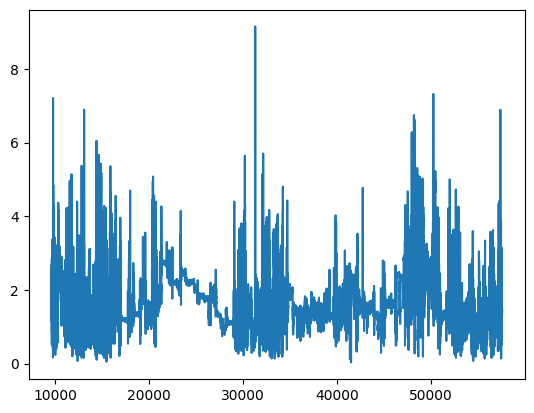

In [228]:
plt.plot(X_table_5min.iloc[0,:])

In [262]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report,recall_score, precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

In [269]:
def test_classifiers(X_train, y_train, X_test, y_test):
    models = {
        'MLP Classifier': MLPClassifier(),  ## --> This is your baseline = chance
        'Logistic Regression': LogisticRegression(),
        'Decision Tree': DecisionTreeClassifier(),
        'Random Forest': RandomForestClassifier(),
        'Gradient Boosting': GradientBoostingClassifier(),
        'K-Nearest Neighbors': KNeighborsClassifier()

    }

    results = {}

    for name, model in models.items():
        pipe = make_pipeline(model)
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        recall = recall_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)

        report = classification_report(y_test, y_pred)

        results[name] = {
            'accuracy': accuracy,
            'report': report,
            'precision' : precision
        }

        print(f"{name}:\n")
        print(f"Recall: {recall}\n")
        print(f"Precision: {precision}\n")
        print(f"Accuracy: {accuracy}\n")
        # table_results = pd.DataFrame({"Recall": recall,"Precision": precision, "Accuracy": accuracy})
        # print(f"Classification Report:\n{report}\n")
        # print(table_results)

    return results

In [270]:
resultats = test_classifiers(X_train, y_train, X_test, y_test)

MLP Classifier:

Recall: 0.75

Precision: 0.5

Accuracy: 0.42857142857142855

Logistic Regression:

Recall: 0.5

Precision: 0.5714285714285714

Accuracy: 0.5

Decision Tree:

Recall: 0.5

Precision: 0.6666666666666666

Accuracy: 0.5714285714285714

Random Forest:

Recall: 0.75

Precision: 0.6

Accuracy: 0.5714285714285714

Gradient Boosting:

Recall: 0.5

Precision: 0.6666666666666666

Accuracy: 0.5714285714285714

K-Nearest Neighbors:

Recall: 0.75

Precision: 0.6

Accuracy: 0.5714285714285714



In [ ]:
'MLP Classifier'
'Logistic Regression'
'Decision Tree'
'Random Forest'
'Gradient Boosting'
'K-Nearest Neighbors'

In [275]:
def test_classifiers2(X_train, y_train, X_test, y_test):
    models = {
        'Random Forest': RandomForestClassifier(),
        'Gradient Boosting': GradientBoostingClassifier(),
        'K-Nearest Neighbors': KNeighborsClassifier()

    }

    results = {}

    for name, model in models.items():
        pipe = make_pipeline(model)
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        recall = recall_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)

        report = classification_report(y_test, y_pred)

        results[name] = {
            'accuracy': accuracy,
            'report': report,
            'precision' : precision
        }

        print(f"{name}:\n")
        print(f"Recall: {recall}\n")
        print(f"Precision: {precision}\n")
        print(f"Accuracy: {accuracy}\n")
        # table_results = pd.DataFrame({"Recall": recall,"Precision": precision, "Accuracy": accuracy})
        # print(f"Classification Report:\n{report}\n")
        # print(table_results)

    return results

In [276]:
resultats2 = test_classifiers2(X_train, y_train, X_test, y_test)

Random Forest:

Recall: 0.625

Precision: 0.5555555555555556

Accuracy: 0.5

Gradient Boosting:

Recall: 0.5

Precision: 0.6666666666666666

Accuracy: 0.5714285714285714

K-Nearest Neighbors:

Recall: 0.75

Precision: 0.6

Accuracy: 0.5714285714285714



In [280]:
# len(resultats)
display(resultats2['Gradient Boosting']['accuracy'])
display(resultats2['Gradient Boosting']['precision'])

0.5714285714285714

0.6666666666666666

In [282]:
# Random Forest
display(resultats2['Random Forest']['accuracy'])
display(resultats2['Random Forest']['precision'])

0.5

0.5555555555555556

In [283]:
def test_classifiers3(X_train, y_train, X_test, y_test):
    models = {
        'K-Nearest Neighbors': KNeighborsClassifier()

    }

    results = {}

    for name, model in models.items():
        pipe = make_pipeline(model)
        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)
        print(y_pred)

        recall = recall_score(y_test, y_pred)
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)

        report = classification_report(y_test, y_pred)

        results[name] = {
            'accuracy': accuracy,
            'report': report,
            'precision' : precision
        }

        print(f"{name}:\n")
        print(f"Recall: {recall}\n")
        print(f"Precision: {precision}\n")
        print(f"Accuracy: {accuracy}\n")
        # table_results = pd.DataFrame({"Recall": recall,"Precision": precision, "Accuracy": accuracy})
        # print(f"Classification Report:\n{report}\n")
        # print(table_results)

    return results

In [284]:
resultsKNN = test_classifiers3(X_train, y_train, X_test, y_test)

K-Nearest Neighbors:

Recall: 0.75

Precision: 0.6

Accuracy: 0.5714285714285714



In [285]:
# K-Nearest Neighbors
display(resultsKNN['K-Nearest Neighbors']['accuracy'])
display(resultsKNN['K-Nearest Neighbors']['precision'])

0.5714285714285714

0.6

# Jing model 

In [242]:
model = GradientBoostingClassifier(n_estimators=200)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
print(f"Accuracy: {accuracy}\n")
print(f"Classification Report:\n{report}\n")

Accuracy: 0.5714285714285714

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.67      0.57         6
           1       0.67      0.50      0.57         8

    accuracy                           0.57        14
   macro avg       0.58      0.58      0.57        14
weighted avg       0.60      0.57      0.57        14


